# Classy words: Exploring Term-Category Association Metrics
### Jason S. Kessler ([@jasonkessler](http://www.twitter.com/JasonKessler))

This notebook makes heavy use of the library Scattertext (https://github.com/JasonKessler/scattertext) for language processing and visualizations.

The data used were scraped from Facebook by Max Woolf.  Please see his original notebook at https://github.com/minimaxir/clickbait-cluster.

In [1]:
import pandas as pd
import numpy as np
import scattertext as st
import sys
import datetime
import nltk
import re
import scipy
import spacy
import altair as alt

from glob import glob
from scipy.stats import rankdata
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nlp = spacy.load('en')

In [3]:
df = pd.concat([pd.read_csv(fn, sep='\t')
                .assign(publication=fn.split('/')[-1].split('_')[0]) 
                for fn in glob('./fb_headlines/*')]).reset_index()
df['status_published'] = pd.to_datetime(df.status_published)
df = df.loc[df.link_name.dropna().index]

In [4]:
df['parse'] = df.link_name.apply(nlp)

In [5]:
df['year_month'] = df.status_published.apply(lambda x: '%s-%s' % (x.year, str(x.month).zfill(2)))
df['year'] = df.status_published.apply(lambda x: x.year)

In [6]:
df['reaction_percentile'] = (df.groupby(['publication', 'year'])['num_reactions']
                             .apply(lambda x: pd.Series(scipy.stats.rankdata(x)/len(x), 
                                                        index=x.index)))
df['reaction_bin'] = (df.reaction_percentile
                      .apply(lambda x: 'Hi' if x > 2./3 else 'Lo' if x < 1./3 else 'Mid'))

In [7]:
year_month_corpus = st.CorpusFromParsedDocuments(df, 
                                                 category_col='year_month', 
                                                 parsed_col='parse', 
                                                 feats_from_spacy_doc=st.PhraseMachinePhrases()).build()

In [217]:
import numpy as np
import pandas as pd

from scattertext.termranking import AbsoluteFrequencyRanker
from scattertext.termscoring.RankDifference import RankDifference


class GanttChart(object):
	def __init__(self,
	             term_doc_matrix,
	             category_to_timestep_func,
	             is_gap_between_sequences_func,
	             timesteps_to_lag=4,
	             num_top_terms_each_timestep=10,
	             num_terms_to_include=40,
	             starting_time_step=None,
	             term_ranker=AbsoluteFrequencyRanker,
	             term_scorer=RankDifference()):
		'''
		Parameters
		----------
		term_doc_matrix : TermDocMatrix
		category_to_timestep_func : lambda
		is_gap_between_sequences_func : lambda
		timesteps_to_lag : int
		num_top_terms_each_timestep : int
		num_terms_to_include : int
		starting_time_step : object
		term_ranker : TermRanker
		term_scorer : TermScorer
		'''
		self.corpus = term_doc_matrix
		self.timesteps_to_lag = timesteps_to_lag
		self.num_top_terms_each_timestep = num_top_terms_each_timestep
		self.num_terms_to_include = num_terms_to_include
		self.is_gap_between_sequences_func = is_gap_between_sequences_func
		self.category_to_timestep_func = category_to_timestep_func
		self.term_ranker = term_ranker
		self.term_scorer = term_scorer
		categories = list(sorted(self.corpus.get_categories()))
		if len(categories) <= timesteps_to_lag:
			raise Exception("The number of categories in the term doc matrix is <= "
			                + str(timesteps_to_lag))
		if starting_time_step is None:
			starting_time_step = categories[timesteps_to_lag + 1]
		self.starting_time_step = starting_time_step

	def make_chart(self):
		task_df = self.get_task_df()
		import altair as alt
		chart = alt.Chart(task_df).mark_bar().encode(
			x='start',
			x2='end',
			y='term',
		)
		return chart

	def _get_term_time_df(self):
		data = []
		tdf = self.term_ranker(self.corpus).get_ranks()
		for cat in sorted(self.corpus.get_categories()):
			if cat >= self.starting_time_step:
				cat_terms_counts = tdf[cat + ' freq'].astype(int)
				scores = self.term_scorer.get_scores(
					tdf[sorted([x for x in tdf.columns if x < cat])[-self.timesteps_to_lag:]]
						.sum(axis=1),
					cat_terms_counts
				)
				prospective_top_terms = scores.sort_values(ascending=False).iloc[:self.num_top_terms_each_timestep]
				top_terms = cat_terms_counts[prospective_top_terms.index][cat_terms_counts[prospective_top_terms.index] > 0]
				for term in top_terms.index:
					data.append({'time': self.category_to_timestep_func(cat),
					             'term': term,
					             'top': 1})
		return pd.DataFrame(data)

	def get_task_df(self):
		term_time_df = self._get_term_time_df()
		terms_to_include = (
			term_time_df
				.groupby('term')['top']
				.sum()
				.sort_values(ascending=False)
				.iloc[:self.num_terms_to_include].index
		)
		task_df = (
			term_time_df[term_time_df.term.isin(terms_to_include)][['time', 'term']]
				.groupby('term')
				.apply(lambda x: pd.Series(self._find_sequences(x['time'])))
				.reset_index()
				.rename({0: 'sequence'}, axis=1)
				.reset_index()
				.assign(start=lambda x: x['sequence'].apply(lambda x: x[0]))
				.assign(end=lambda x: x['sequence'].apply(lambda x: x[1]))
			[['term', 'start', 'end']]
		)
		return task_df

	def _find_sequences(self, time_steps):
		min_timestep = None
		last_timestep = None
		sequences = []
		for cur_timestep in sorted(time_steps):
			if min_timestep is None:
				min_timestep = cur_timestep
			elif self.is_gap_between_sequences_func(last_timestep, cur_timestep):
				sequences.append([min_timestep, last_timestep])
				min_timestep = cur_timestep
			last_timestep = cur_timestep
		if sequences == [] or sequences[-1][1] != last_timestep:
			sequences.append([min_timestep, last_timestep])
		return sequences


In [218]:
#year_month_corpus_compact = year_month_corpus.compact(st.CompactTerms(minimum_term_count=2))

In [219]:
chart_start_year = '2013-01'
category_to_datetime = lambda category: pd.to_datetime(datetime.datetime(*([int(t) for t in category.split('-')] + [1])))
timesteps_to_lag = 4
num_top_terms_each_timestep = 10 
num_terms_to_include = 40 
is_gap_between_sequences = lambda t1, t2: (t1 - t2).days > 31
corpus = year_month_corpus

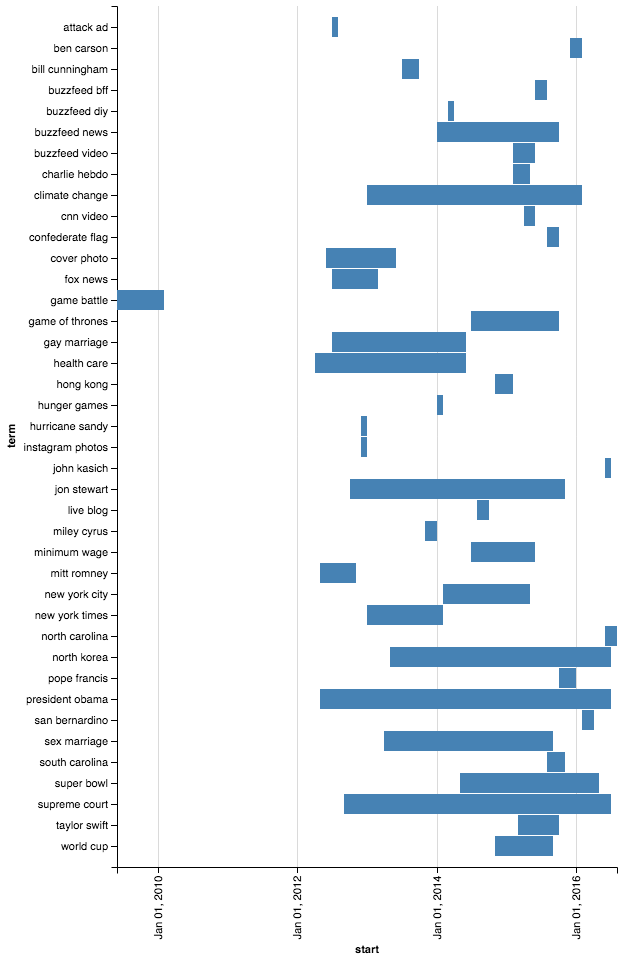

In [221]:
GanttChart(year_month_corpus_compact, category_to_datetime, is_gap_between_sequences).make_chart()

In [196]:
tdf = AbsoluteFrequencyRanker(year_month_corpus_compact).get_ranks()

In [91]:
tdf['1913-02 freq'].sort_values(ascending=False)

term
times square                                   1
| upworthy                                     0
mom reacts                                     0
street art                                     0
mel gibson                                     0
cbs news                                       0
good use                                       0
joins twitter                                  0
oil spill                                      0
tech support                                   0
bill nye on                                    0
angry mom                                      0
hail storm                                     0
kung fu                                        0
insane clown posse                             0
kids reenact                                   0
olivia munn                                    0
goldman sachs                                  0
earth day                                      0
factory workers                                0
human trafficki

In [85]:
term_time_df.groupby('term').apply(lambda x: len(list(x['time']))).sort_values(ascending=False)
term_time_df[term_time_df.term == 'michigan primary']

,term,time,top
8,michigan primary,1918-06-01,1
17,michigan primary,1919-06-01,1
26,michigan primary,1926-02-01,1
36,michigan primary,1926-05-01,1
46,michigan primary,1928-11-01,1
56,michigan primary,1933-04-01,1
65,michigan primary,1933-12-01,1
76,michigan primary,1934-01-01,1
86,michigan primary,1934-02-01,1
96,michigan primary,1940-04-01,1


In [37]:
class GanttChart(object):
    def __init__(self,
                 corpus,
                 category_to_datetime_func,
                 is_gap_between_sequences_func,
                 timesteps_to_lag = 4,
                 num_top_terms_each_timestep = 10,
                 num_terms_to_include = 40,
                 term_ranker = st.AbsoluteFrequencyRanker,
                 term_scorer = st.RankDifference):
        self.corpus = corpus
        self.timesteps_to_lag = timesteps_to_lag
        self.num_top_terms_each_timestep = num_top_terms_each_timestep
        self.num_terms_to_include = num_terms_to_include      
        self.is_gap_between_sequences_func = is_gap_between_sequences_func
        self.category_to_datetime_func = category_to_datetime_func
        
    def _find_sequences(self, time_steps):
        min_timestep = None
        max_timestep = None
        last_timestep = None
        gaps = []
        for cur_timestep in sorted(time_steps):
            if min_timestep is None:
                min_timestep = cur_timestep
            elif self.is_gap_between_sequences_func(cur_timestep, last_timestep):
                gaps.append([min_timestep, last_timestep])
                min_timestep = cur_timestep
            last_timestep = cur_timestep
        if gaps == [] or gaps[-1][1] != cur_timestep:
            gaps.append([min_timestep, cur_timestep])
        return gaps        

    def make_chart(self):
        data = []
        tdf = self.term_ranker(corpus).get_ranks()
        for cat in sorted(self.corpus.get_categories()):
            if cat >= chart_start_year:
                scores = st.RankDifference().get_scores(
                    tdf[sorted([x for x in tdf.columns if x < cat])[-timesteps_to_lag:]].sum(axis=1), 
                    tdf[cat].astype(int))
                for term in tdf.index[np.argsort(-scores)[:num_top_terms_each_timestep]]:
                    data.append({'time': category_to_datetime(cat), 
                                 'term': term, 
                                 'top': 1})

        term_time_df = pd.DataFrame(data)
        terms_to_include = (term_time_df
                            .groupby('term')
                            ['top']
                            .sum()
                            .sort_values(ascending=False)
                            .iloc[:num_terms_to_include].index)
        task_df = (term_time_df[term_time_df
                                .term.isin(terms_to_include)][['time', 'term']]
                   .groupby('term')
                       .apply(lambda x: pd.Series(find_sequences(x['time'])))
                       .reset_index()
                       .rename({0:'sequence'}, axis=1)
                   .reset_index()
                   .assign(start=lambda x: x['sequence'].apply(lambda x: x[0]))
                   .assign(end=lambda x: x['sequence'].apply(lambda x: x[1]))
                   [['term', 'start', 'end']])
        #print(task_df)
        chart = alt.Chart(task_df).mark_bar().encode(
            x = 'start',
            x2 = 'end',
            y = 'term',
        )
        return chart

SyntaxError: invalid syntax (<ipython-input-37-57bf62f7605a>, line 6)

In [20]:
chart = generate_diachronic_chart(category_to_datetime, 
                          timesteps_to_lag, 
                          num_top_terms_each_timestep, 
                          num_terms_to_include, 
                          is_gap_between_sequences,
                          corpus)

> <ipython-input-18-1571ba5eb391>(54)generate_diachronic_chart()
-> chart = alt.Chart(task_df).mark_bar().encode(
(Pdb) c


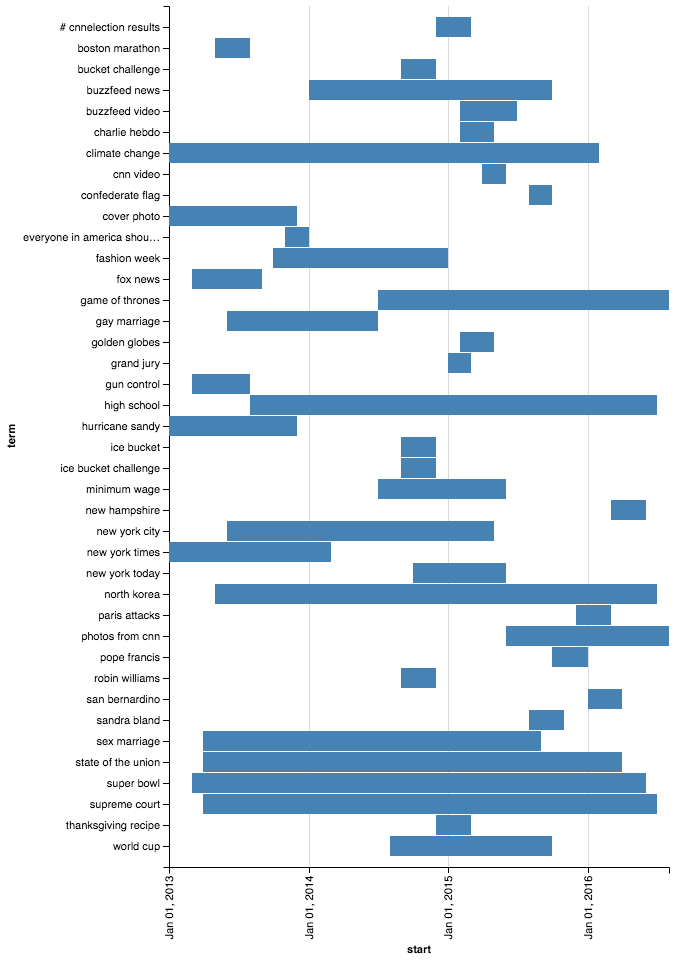

In [22]:
chart